In [1]:
from glob import glob
from astropy.io import fits
from scipy import stats
import os
import random

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import pandas as pd

# statistics
from astropy.stats import biweight_location, biweight_scale, sigma_clipped_stats
from scipy.stats import median_abs_deviation

#Permutations
from itertools import permutations

# configuration
np.set_printoptions(linewidth=120) # para que se vea
plt.rcParams["image.cmap"] = "gray" # https://matplotlib.org/stable/users/explain/colors/colormaps.html
plt.rcParams["image.origin"] = "lower"

def quantile_imshow(img,lower=0.01,upper=0.99,**kwargs):
    img_vmin = np.quantile(img,lower)
    img_vmax = np.quantile(img,upper)
    return plt.imshow(img,vmin=img_vmin,vmax=img_vmax,**kwargs)

In [2]:
FLATS = glob("flats/FLAT*.fit")
BIAS = glob("bias/bias*.fit")
print(FLATS)

['flats/FLAT0132.fit', 'flats/FLAT0091.fit', 'flats/FLAT0251.fit', 'flats/FLAT0133.fit', 'flats/FLAT0131.fit', 'flats/FLAT0092.fit', 'flats/FLAT0253.fit', 'flats/FLAT0252.fit', 'flats/FLAT0044.fit', 'flats/FLAT0093.fit', 'flats/FLAT0134.fit', 'flats/FLAT0041.fit', 'flats/FLAT0094.fit', 'flats/FLAT0043.fit', 'flats/FLAT0254.fit', 'flats/FLAT0042.fit', 'flats/FLAT0233.fit', 'flats/FLAT0232.fit', 'flats/FLAT0231.fit', 'flats/FLAT0184.fit', 'flats/FLAT0234.fit', 'flats/FLAT0181.fit', 'flats/FLAT0183.fit', 'flats/FLAT0182.fit', 'flats/FLAT0164.fit', 'flats/FLAT0204.fit', 'flats/FLAT0162.fit', 'flats/FLAT0201.fit', 'flats/FLAT0163.fit', 'flats/FLAT0161.fit', 'flats/FLAT0203.fit', 'flats/FLAT0202.fit', 'flats/FLAT0113.fit', 'flats/FLAT0112.fit', 'flats/FLAT0064.fit', 'flats/FLAT0111.fit', 'flats/FLAT0061.fit', 'flats/FLAT0114.fit', 'flats/FLAT0062.fit', 'flats/FLAT0063.fit']


In [50]:
len(FLATS)

40

Se organizan por orden los datos obtenidos

In [3]:
groups_dict = {}
sub_group = []
for flat in FLATS:
    time = flat[10:13]
    if time not in groups_dict:
        groups_dict[time] = []
    groups_dict[time].append(flat)
        
groups = list(groups_dict.values())

In [4]:
for group in groups:
    for image in group:
        output = fits.getdata(image)
        print(np.mean(output))

32923.054909650135
32688.08489042676
33601.91254133026
33644.25774445726
20612.208032807896
21040.284252210688
21067.654971164935
22108.122473407664
58354.520753556324
62989.49720876586
62173.156883250034
63944.15855440215
12426.458582596437
12327.1630911188
12429.112415737536
12162.269050365245
55480.523537101115
54952.7342611816
54859.14570549788
54891.248089196466
44529.5210713828
43445.961732666925
44019.31133410227
43204.4071459695
39549.09339741125
40089.40811739075
41166.2394027938
39788.962404203514
47969.67511726259
47561.81575291554
46375.42031526336
48212.687220299886
27779.63806740997
25578.926692297835
28916.220825323595
25842.249450211457
12155.763962578496
13767.708468537741
13273.166535947712
13969.640148660772


Se obtienen pares de flats para el mismo tiempo de exposición

In [5]:
paired_groups = []

for group in groups:
   
    paired_group = [(fits.getdata(pair[0]), fits.getdata(pair[1])) for pair in permutations(group, 2)]
    paired_groups.append(paired_group)

In [52]:
len(paired_groups[0])


12

Se selecciona un par de imágenes flats de las formadas anteriormente y se les resta el bias

In [7]:
bias_images = [fits.getdata(f) for f in BIAS]
flat_images = [fits.getdata(f) for f in FLATS]      

Se obtiene el promedio de las imágenes BIAS

In [8]:
bias_permutations = permutations(bias_images, 2)

In [9]:
combinations = [np.std(pair[0].astype("float64") - pair[1].astype("float64")) for pair in bias_permutations]

In [18]:
bias_permutations

In [25]:
bias_permutations = permutations(bias_images, 2)
bias_pairs = list(bias_permutations)

In [26]:
bias_pairs

[(array([[1090, 1127, 1089, ..., 1090, 1034, 1037],
         [1088, 1108, 1112, ..., 1050, 1028, 1018],
         [1090, 1095, 1094, ..., 1026, 1038, 1054],
         ...,
         [1133, 1095, 1098, ..., 1034, 1032, 1035],
         [1105, 1113, 1116, ..., 1029, 1012, 1055],
         [1102, 1089, 1110, ..., 1014, 1040, 1021]], dtype=uint16),
  array([[1071, 1097, 1105, ..., 1039, 1020, 1030],
         [1115, 1111, 1086, ..., 1025, 1057, 1037],
         [1093, 1089, 1104, ..., 1043, 1051, 1038],
         ...,
         [1107, 1108, 1067, ..., 1037, 1040, 1010],
         [1122, 1105, 1106, ..., 1031, 1027, 1028],
         [1127, 1101, 1112, ..., 1038, 1029, 1026]], dtype=uint16)),
 (array([[1090, 1127, 1089, ..., 1090, 1034, 1037],
         [1088, 1108, 1112, ..., 1050, 1028, 1018],
         [1090, 1095, 1094, ..., 1026, 1038, 1054],
         ...,
         [1133, 1095, 1098, ..., 1034, 1032, 1035],
         [1105, 1113, 1116, ..., 1029, 1012, 1055],
         [1102, 1089, 1110, ..., 1014, 10

(array([  56.,  296., 1184., 1932., 2542., 2136., 1154.,  482.,  100.,   18.]),
 array([17.22017345, 17.2360298 , 17.25188615, 17.2677425 , 17.28359884, 17.29945519, 17.31531154, 17.33116789,
        17.34702424, 17.36288059, 17.37873694]),
 <BarContainer object of 10 artists>)

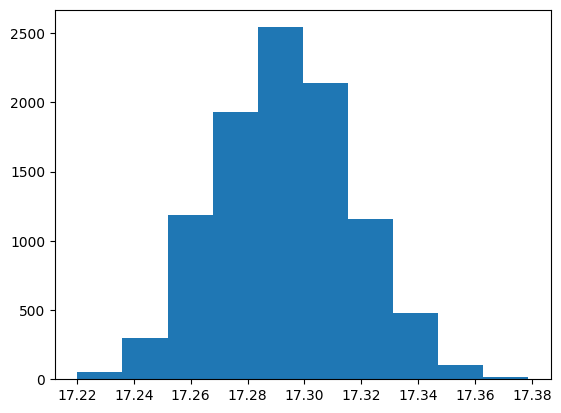

In [10]:
plt.hist(combinations)

In [11]:
bias_mean = [image_b.astype('float64') for image_b in bias_images ]
bias_mean_1= sum(bias_mean[:50])/50
bias_mean_2 = sum(bias_mean[50:])/50
print(bias_mean_1, bias_mean_2)

[[1100.36 1100.86 1098.58 ... 1036.62 1033.7  1032.96]
 [1097.82 1101.9  1099.48 ... 1033.98 1035.6  1032.04]
 [1098.26 1100.8  1098.8  ... 1031.82 1034.34 1035.82]
 ...
 [1100.32 1101.94 1095.34 ... 1034.36 1037.1  1033.28]
 [1100.64 1103.94 1095.62 ... 1032.98 1033.76 1034.66]
 [1097.16 1099.48 1097.46 ... 1038.   1034.9  1035.66]] [[1103.32 1101.72 1097.64 ... 1033.66 1035.92 1037.6 ]
 [1102.38 1101.48 1095.5  ... 1033.6  1034.12 1031.74]
 [1102.72 1097.66 1096.94 ... 1035.34 1036.74 1034.4 ]
 ...
 [1101.92 1101.24 1099.12 ... 1036.02 1032.74 1033.2 ]
 [1099.96 1100.36 1097.42 ... 1035.22 1034.28 1033.02]
 [1098.46 1098.46 1096.42 ... 1036.38 1036.84 1032.84]]


In [27]:
def subtract_bias(paired_groups, bias_pairs):
    summed_images = []
    difference_images = []
    for sub_group in paired_groups:
        for pair in sub_group:
            f1, f2 = pair
            f1 = f1.astype('float64')
            f2 = f2.astype('float64')
            b1, b2 = random.choice(bias_pairs)
            b1 = b1.astype('float64')
            b2 = b2.astype('float64')
            f1 -= b1
            f2 -= b2
            summed_image = (f1+f2)/2
            difference_image = np.var((f1-f2).ravel())/2
            summed_images.append(summed_image)
            difference_images.append(difference_image)
    return summed_images, difference_images

In [28]:
summed_images, difference_images = subtract_bias(paired_groups, bias_pairs)

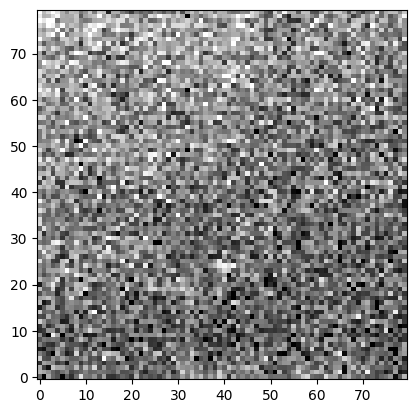

In [29]:
quantile_imshow(summed_images[0][20:100, 20:100])

Se escoge una región de la imagen

In [103]:
mean_level_summed = [np.mean(image[20:100, 20:100]) for image in summed_images]
variance_ = difference_images

In [104]:
combinadas = list(zip(mean_level_summed, difference_images))
combinadas_ordenadas = sorted(combinadas, key=lambda x: x[0])

mean_level_summed_sorted, variance_sorted = zip(*combinadas_ordenadas)

mean_level_summed_sorted = list(mean_level_summed_sorted)
variance_sorted = list(variance_sorted)

In [105]:
import matplotlib.patches as patches

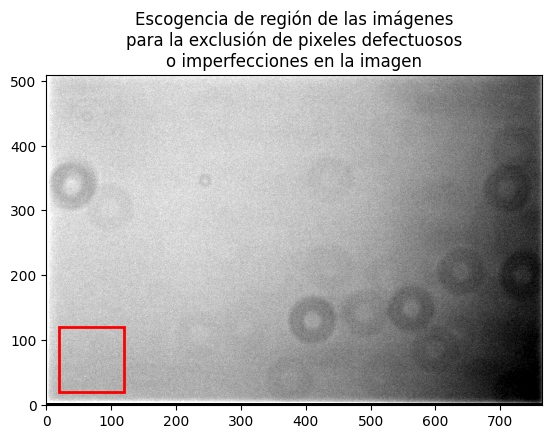

In [106]:
quantile_imshow(summed_images[0])
rectangle = patches.Rectangle((20, 20),100, 100, linewidth=2, edgecolor='r', facecolor='none') 
plt.gca().add_patch(rectangle)
plt.title("Escogencia de región de las imágenes\npara la exclusión de pixeles defectuosos\no imperfecciones en la imagen")
# Mostrar la imagen con el rectángulo
plt.show()

In [107]:
for i, e in zip(mean_level_summed_sorted, variance_sorted):
    print(i,e)

11478.846328125 9675.367174299447
11480.495546875 9676.790911879778
11517.851171875 13761.597863618454
11518.31765625 13755.009367192166
11529.568046875 17113.192274999343
11531.253359375 17117.49124163483
11573.031328125 9532.395352293626
11573.501640625 9528.376843691842
11586.05703125 11952.8131575754
11586.27890625 11952.714072631528
11622.29390625 9088.876350721817
11623.398046875 9089.08198861369
11944.187578125 12557.372782599057
11945.174765625 12561.44523988288
12181.4825 19068.21957015583
12183.034609375 19067.244411390482
12262.140625 19919.513042156796
12263.7759375 19917.165617418505
12696.6509375 10640.362783415881
12697.456640625 10645.846370854115
12777.55796875 11186.377618059108
12778.222890625 11182.756082422571
13015.106484375 10762.986239553167
13016.650546875 10757.987031457751
20347.8178125 16237.314699935418
20350.6165625 16239.458096830878
20353.276796875 18799.54832315046
20354.031796875 18786.86113932854
20638.728046875 15382.200212896443
20640.074140625 1537

Ganancia: 1.2354055129499837  +- 0.055959946175481515
R^2: 0.7996240611939247
Ruido: 15.106671723651743 +- 0.8453685365462202


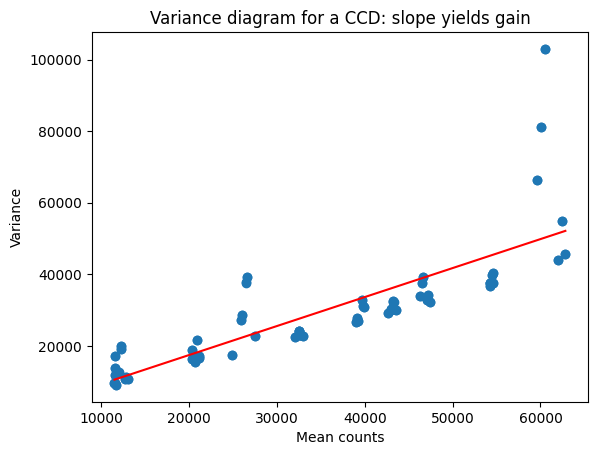

In [108]:
plt.scatter(mean_level_summed_sorted, variance_sorted)
datos = stats.linregress(mean_level_summed_sorted, variance_sorted)
m = datos.slope
b = datos.intercept
linea_regresion = [m*x + b for x in mean_level_summed_sorted]
plt.plot(mean_level_summed_sorted, linea_regresion, 'r', label='Línea de regresión')
ganancia=1/m
plt.title("Variance diagram for a CCD: slope yields gain")
plt.xlabel("Mean counts")
plt.ylabel("Variance")
print(f"Ganancia: {ganancia}  +- {datos[4]}\nR^2: {datos[2]}")
print(f"Ruido: {ganancia*np.mean(combinations)/(np.sqrt(2))} +- {datos[4]*ganancia*np.mean(combinations)/(np.sqrt(2))}")

In [109]:
slope, intercept, r_value, p_value, std_err = stats.linregress(mean_level_summed, difference_images)

mean_level_summed_filtered = []
difference_images_filtered = []
for xi, yi in zip(mean_level_summed, difference_images):
    y_expected = slope * xi + intercept
    if np.abs((yi - y_expected) / y_expected) < 0.3:
        mean_level_summed_filtered.append(xi)
        difference_images_filtered.append(yi)

mean_level_summed_filtered = np.array(mean_level_summed_filtered)
difference_images_filtered = np.array(difference_images_filtered)

Ganancia: 1.4994614880936044 +- 0.01786432791585917
R^2: 0.7996240611939247
Ruido: 18.335576638960244 +- 0.3275527536047528


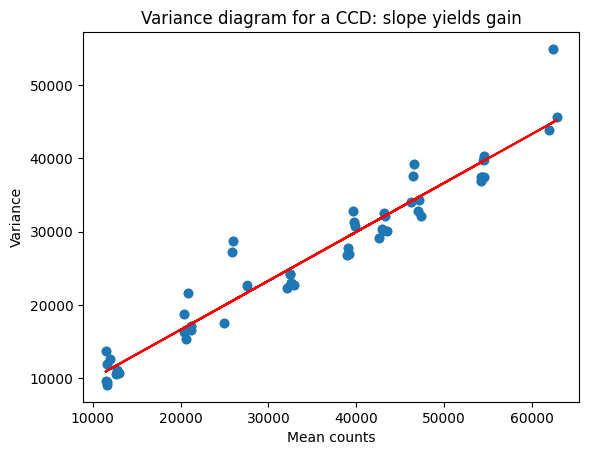

In [124]:
plt.scatter(mean_level_summed_filtered, difference_images_filtered)
datos_2 = stats.linregress(mean_level_summed_filtered, difference_images_filtered)
m = datos_2.slope
b = datos_2.intercept
linea_regresion = [m*x + b for x in mean_level_summed_filtered]
plt.plot(mean_level_summed_filtered, linea_regresion, 'r', label='Línea de regresión')
ganancia_2=1/m
plt.title("Variance diagram for a CCD: slope yields gain")
plt.xlabel("Mean counts")
plt.ylabel("Variance")
print(f"Ganancia: {ganancia_2} +- {datos_2[4]}\nR^2: {datos[2]}")
print(f"Ruido: {ganancia_2*np.mean(combinations)/(np.sqrt(2))} +- {datos_2[4]*ganancia_2*np.mean(combinations)/(np.sqrt(2))}")

Método para deteminar ganancia y ruido de lectura a partir de la toría

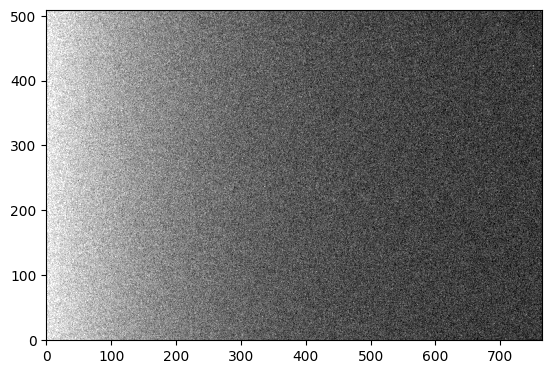

In [111]:
quantile_imshow(bias_images[3])

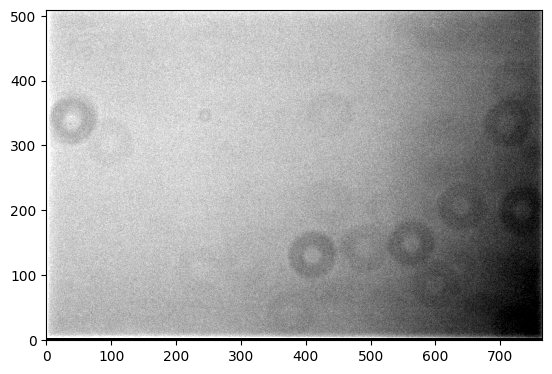

In [112]:
quantile_imshow(flat_images[3])

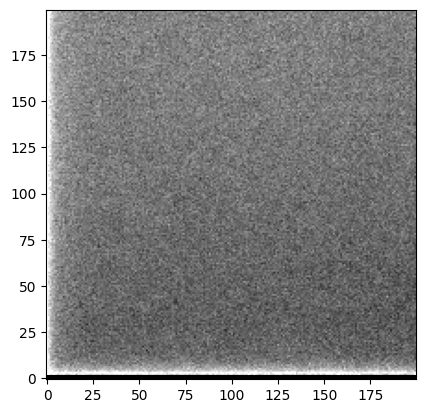

In [113]:
quantile_imshow(flat_images[3][:200, :200])

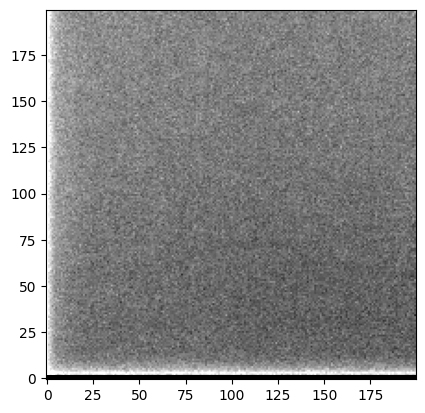

In [114]:
trimmed_flats = [image[:200, :200] for image in flat_images]
quantile_imshow(trimmed_flats[0])

Se crea una función para calcular la ganancia a partir de los grupos de flats

In [115]:
def ganancia_ruido(f1, f2, bias_pairs):
    f1 = f1.astype('float64')
    f2 = f2.astype('float64')
    b1, b2 = random.choice(bias_pairs)
    b1 = b1.astype('float64')
    b2 = b2.astype('float64')
    f1_mean = np.mean(f1)
    f2_mean = np.mean(f2)
    b1_mean = np.mean(b1)
    b2_mean = np.mean(b2)
    sigma_F = np.var(f1-f2)
    sigma_B = np.var(b1-b2)
    ganancia = (f1_mean + f2_mean - b1_mean - b2_mean)/(sigma_F - sigma_B)
    ruido = ganancia*np.sqrt(sigma_B/2)
    return ganancia, ruido


In [116]:
lista_ganancias = []
lista_ruido = []
for time in paired_groups:
    for pair in time:
        f1, f2 = pair
        ganancia, ruido = ganancia_ruido(f1[30:90, 30:90],f2[30:90, 30:90], bias_pairs)
        lista_ganancias.append(ganancia)
        lista_ruido.append(ruido)

In [125]:
print(f"Ganancia: {np.mean(lista_ganancias)} +- {np.std(lista_ganancias)}")
print(f"Ruido de lectura: {np.mean(lista_ruido)} +- {np.std(lista_ruido)}")

Ganancia: 1.4928358285935621 +- 0.05256679993661759
Ruido de lectura: 18.256352245096057 +- 0.6450683652055684


Se determina la ganancia con la fórmula de ganancia = 1/pendiente